# Hotel Cancellation Prediction Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pydotplus
import eli5 # Feature importance evaluation

## Loading Preparing the Dataset

In [3]:
full_data = pd.read_csv('hotel_booking_cleaned.csv')
pd.options.display.max_columns = None
full_data.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,0,0,Transient,0.0,0,0,Check-Out,1/7/2015,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,0,0,Transient,0.0,0,0,Check-Out,1/7/2015,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,0,0,Transient,75.0,0,0,Check-Out,2/7/2015,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,0,0,Transient,75.0,0,0,Check-Out,2/7/2015,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,0,0,Transient,98.0,0,1,Check-Out,3/7/2015,Linda Hines,LHines@verizon.com,713-226-5883,************5498


In [4]:
# absolute cancelations:
total_cancelations = full_data["is_canceled"].sum()
rh_cancelations = full_data.loc[full_data["hotel"] == "Resort Hotel"]["is_canceled"].sum()
ch_cancelations = full_data.loc[full_data["hotel"] == "City Hotel"]["is_canceled"].sum()

# as percent:
rel_cancel = total_cancelations / full_data.shape[0] * 100
rh_rel_cancel = rh_cancelations / full_data.loc[full_data["hotel"] == "Resort Hotel"].shape[0] * 100
ch_rel_cancel = ch_cancelations / full_data.loc[full_data["hotel"] == "City Hotel"].shape[0] * 100

print(f"Total bookings canceled: {total_cancelations:,} ({rel_cancel:.0f} %)")
print(f"Resort hotel bookings canceled: {rh_cancelations:,} ({rh_rel_cancel:.0f} %)")
print(f"City hotel bookings canceled: {ch_cancelations:,} ({ch_rel_cancel:.0f} %)")

Total bookings canceled: 44,199 (37 %)
Resort hotel bookings canceled: 11,120 (28 %)
City hotel bookings canceled: 33,079 (42 %)


The cancellation data did not seem imbalanced so no further adjustment was required. 

In [5]:
pairwise_corr = full_data.corr()
pairwise_corr.style.apply(lambda x: ["background: red" if abs(v) > 0.8 else "" for v in x], axis = 1)

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
is_canceled,1.000000,0.292876,0.016622,0.008315,-0.005948,-0.001323,0.025542,0.058182,0.004851,-0.032569,-0.083745,0.110139,-0.057365,-0.144832,-0.046770,-0.083594,0.054301,0.046492,-0.195701,-0.234877
lead_time,0.292876,1.000000,0.040334,0.127046,0.002306,0.085985,0.166892,0.117575,-0.037878,-0.021003,-0.123209,0.086025,-0.073599,0.002230,-0.013114,-0.085854,0.170008,-0.065018,-0.116624,-0.095949
arrival_date_year,0.016622,0.040334,1.000000,-0.540373,-0.000121,0.021694,0.031203,0.030266,0.054710,-0.013192,0.010281,-0.119905,0.029234,0.031416,0.056438,0.033682,-0.056348,0.198429,-0.013812,0.108610
arrival_date_week_number,0.008315,0.127046,-0.540373,1.000000,0.066572,0.018629,0.016047,0.026567,0.005556,0.010417,-0.031125,0.035493,-0.021009,0.006311,-0.018225,-0.032912,0.022677,0.076281,0.001980,0.026202
arrival_date_day_of_month,-0.005948,0.002306,-0.000121,0.066572,1.000000,-0.016225,-0.028362,-0.001754,0.014550,-0.000235,-0.006471,-0.027027,-0.000306,0.011266,0.000159,0.003667,0.022532,0.030291,0.008569,0.003026
stays_in_weekend_nights,-0.001323,0.085985,0.021694,0.018629,-0.016225,1.000000,0.494175,0.094759,0.046135,0.018607,-0.086009,-0.012769,-0.042859,0.050191,0.162411,-0.080783,-0.054399,0.050670,-0.018520,0.073124
stays_in_week_nights,0.025542,0.166892,0.031203,0.016047,-0.028362,0.494175,1.000000,0.096214,0.044652,0.020373,-0.095302,-0.013976,-0.048873,0.080018,0.196777,-0.044437,-0.002026,0.066847,-0.024933,0.068738
adults,0.058182,0.117575,0.030266,0.026567,-0.001754,0.094759,0.096214,1.000000,0.029409,0.017890,-0.140973,-0.007070,-0.108856,-0.041472,0.023370,-0.166182,-0.008365,0.224253,0.014438,0.123353
children,0.004851,-0.037878,0.054710,0.005556,0.014550,0.046135,0.044652,0.029409,1.000000,0.023999,-0.032475,-0.024755,-0.021078,0.051000,0.050461,-0.042554,-0.033293,0.325057,0.056247,0.081747
babies,-0.032569,-0.021003,-0.013192,0.010417,-0.000235,0.018607,0.020373,0.017890,0.023999,1.000000,-0.008813,-0.007509,-0.006552,0.085605,0.030235,-0.009426,-0.010627,0.029043,0.037389,0.097939


From the pairwise correlation table above, none of the numerical features show significant pair-wise correlation of more than 0.8. Hence, no further feature engineering was required. 

In [6]:
pd.DataFrame(full_data.corr()['is_canceled'].abs().sort_values(ascending=False)[1:])

,is_canceled
lead_time,0.292876
total_of_special_requests,0.234877
required_car_parking_spaces,0.195701
booking_changes,0.144832
previous_cancellations,0.110139
is_repeated_guest,0.083745
company,0.083594
adults,0.058182
previous_bookings_not_canceled,0.057365
days_in_waiting_list,0.054301


From the correlation table with the feature *is_cancelled*, the following features are the 5 most important numerical features correlated to cancellation
1. "lead_time"
2. "total_of_special_requests"*
3. "required_car_parking_spaces"
4. "booking_changes"
5. "previous_cancellations"


In [7]:
full_data.groupby("is_canceled")["reservation_status"].value_counts()

is_canceled  reservation_status
0            Check-Out             75011
1            Canceled              42993
             No-Show                1206
Name: reservation_status, dtype: int64

Out of the categorical features, we will exclude *reservation_status* as it is not meaningful for predicting cancellation since the statuses *Canceled* and *No-Show* comprise of all booking cancellations. 

We will also exclude features that may lead to further leakage as these data may not be available at the time of prediction. 
1. *assigned_room_type*
2. *booking_changes*
3. *days_in_waiting_list*

We will also exclude *country* and *arrival_date_year* to make the model more general. We will retain *arrival_date_week_number* and *arrival_date_day_of_month* to account for the possible seasonality. 

In [8]:
# columns excluded to make the model more general and to prevent leakage
# reservation_status
# arrival_date_year
# assigned_room_type
# booking_changes
# days_in_waiting_list
# country

num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

# Separate features and predicted value
features = num_features + cat_features
X = full_data.drop(["is_canceled"], axis=1)[features]
y = full_data["is_canceled"]

Preprocessing for Pipeline

In [9]:
# preprocess numerical feats:
# fill missing values as default value = 0
num_transformer = SimpleImputer(strategy="constant")

# Preprocessing for categorical features:
# fill missing values as "Unknown" and ignore unknown categories
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical features:
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])

We will test the following models for prediction: 
1. Decision Tree
2. Random Forest
3. Logistic Regression

The models will be compared using the **F1 score** as we are mainly interested in the models' overall prediction of cancellation (positives), as opposed to just accuracy (considers equal importance for both cancelled and non-cancelled bookings), precision (proportion of modelled positives) or recall (proportion of actual positives). 

In [10]:
# define models to test:
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1))]

# split data into '4-folds' for cross validation
# use shuffle to ensure random distribution of data
kfolds = 4 
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in base_models:
    # pack preprocessing of data and the model in a pipeline:
    model_steps = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    
    # get cross validation score for each model:
    cv_results = cross_val_score(model_steps, 
                                 X, y, 
                                 cv=split,
                                 scoring="f1",
                                 n_jobs=-1)
    # output:
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"{name} cross validation F1 score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")


DT_model cross validation F1 score: 0.7667 +/- 0.0023 (std) min: 0.7646, max: 0.7706
RF_model cross validation F1 score: 0.8092 +/- 0.0018 (std) min: 0.8067, max: 0.8112
LR_model cross validation F1 score: 0.6893 +/- 0.0042 (std) min: 0.6835, max: 0.6944


Base on the results above, the Random Forest performed the best followed by decision tree. We will further explore each model in the subsequent sections below, specifically the important features. 

## Random Forest

In [11]:
# fit model(pipeline) so values can be accessed:
RF_model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', base_models[1][1])])
RF_model_pipe.fit(X,y)

# Names of all (encoded) features are needed.
# Get names of columns from One Hot Encoding:
RF_onehot_columns = list(RF_model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names_out(input_features=cat_features))

# Add num_features for full list.
# Order must be as in definition of X, where num_features are first: 
RF_feat_imp_list = num_features + RF_onehot_columns

# show 10 most important features, provide names of features:
RF_feat_imp_df = eli5.formatters.as_dataframe.explain_weights_df(
    RF_model_pipe.named_steps['model'],
    feature_names=RF_feat_imp_list)
RF_feat_imp_df.head(10)

,feature,weight,std
0,lead_time,0.150819,0.020657
1,adr,0.098484,0.005876
2,deposit_type_No Deposit,0.084192,0.082985
3,arrival_date_day_of_month,0.072156,0.002704
4,deposit_type_Non Refund,0.067194,0.078761
5,total_of_special_requests,0.063282,0.017354
6,arrival_date_week_number,0.054834,0.002826
7,stays_in_week_nights,0.046073,0.003907
8,agent,0.045671,0.009660
9,previous_cancellations,0.038901,0.017922


In [12]:
# Confusion Matrix
yhat_RF = cross_val_predict(RF_model_pipe, X, y, cv=split)
conf_mat_RF = confusion_matrix(y, yhat_RF, labels=RF_model_pipe.classes_)
print(conf_mat_RF)

[[69625  5386]
 [10504 33695]]


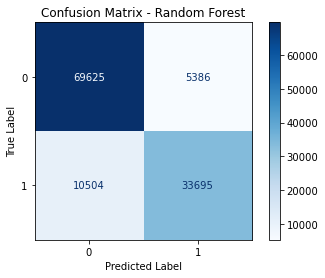

In [13]:
color = 'black'
matrix_RF = ConfusionMatrixDisplay(confusion_matrix=conf_mat_RF)
matrix_RF.plot(cmap=plt.cm.Blues, values_format='')
matrix_RF.ax_.set_title('Confusion Matrix - Random Forest', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

## Decision Tree

In [14]:
# fit model(pipeline) so values can be accessed:
DT_model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', base_models[0][1])])
DT_model_pipe.fit(X,y)

# Names of all (encoded) features are needed.
# Get names of columns from One Hot Encoding:
DT_onehot_columns = list(DT_model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names_out(input_features=cat_features))

# Add num_features for full list.
# Order must be as in definition of X, where num_features are first: 
DT_feat_imp_list = num_features + DT_onehot_columns

# show 10 most important features, provide names of features:
DT_feat_imp_df = eli5.formatters.as_dataframe.explain_weights_df(
    DT_model_pipe.named_steps['model'],
    feature_names=DT_feat_imp_list)
DT_feat_imp_df.head(10)

,feature,weight
0,deposit_type_Non Refund,0.238431
1,lead_time,0.152273
2,adr,0.099711
3,arrival_date_day_of_month,0.069356
4,total_of_special_requests,0.055473
5,arrival_date_week_number,0.051238
6,agent,0.046916
7,stays_in_week_nights,0.039545
8,market_segment_Online TA,0.039421
9,previous_cancellations,0.032810


In [15]:
# Confusion Matrix
yhat_DT = cross_val_predict(DT_model_pipe, X, y, cv=split)
conf_mat_DT = confusion_matrix(y, yhat_DT)
print(conf_mat_DT)

[[64349 10662]
 [10090 34109]]


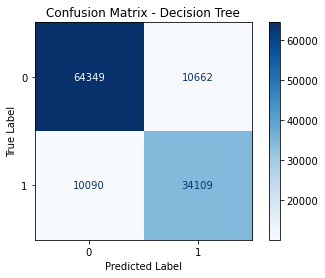

In [16]:
color = 'black'
matrix_DT = ConfusionMatrixDisplay(confusion_matrix=conf_mat_DT)
matrix_DT.plot(cmap=plt.cm.Blues, values_format='')
matrix_DT.ax_.set_title('Confusion Matrix - Decision Tree', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

From both model results, the top 3 important features are Deposit Type, Booking Lead Time and Average Daily Rate. We will investigate each feature and see if we can find any further insights. 

## Booking Lead Time

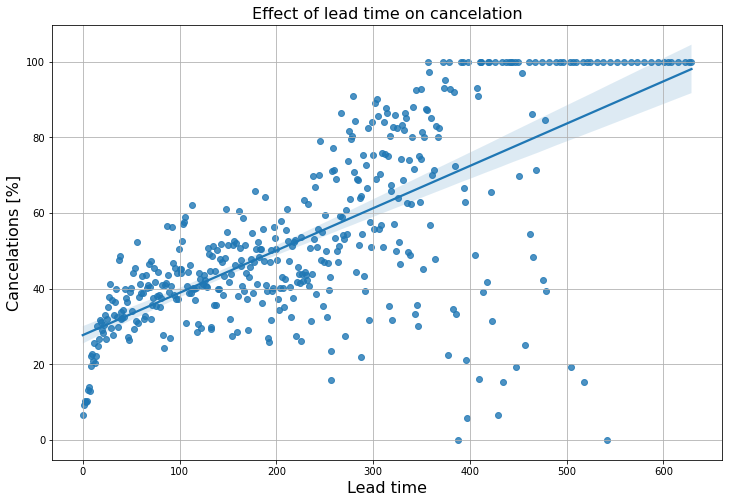

In [17]:
# group data for lead_time:
lead_cancel_data = full_data.groupby("lead_time")["is_canceled"].describe()
# use only lead_times wih more than 10 bookings for graph:
lead_cancel_data_10 = lead_cancel_data.loc[lead_cancel_data["count"] >= 10]

#show figure:
plt.figure(figsize=(12, 8))
sns.regplot(x=lead_cancel_data_10.index, y=lead_cancel_data_10["mean"].values * 100)
plt.title("Effect of lead time on cancelation", fontsize=16)
plt.xlabel("Lead time", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.grid()
plt.show()

The data shows that cancellations generally occur when the booking is made with long lead times. Shorter lead time bookings may be presumed to have been made with some urgency and are thus less prone to cancellations. 

## ADR

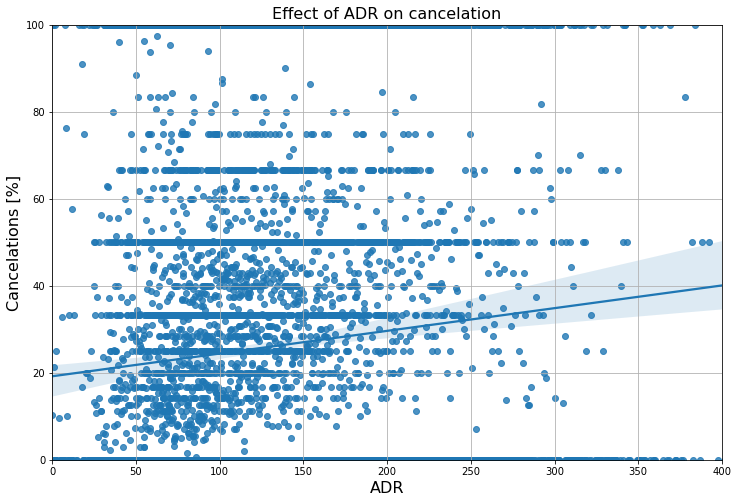

In [18]:
# group data for adr:
adr_cancel_data = full_data.groupby("adr")["is_canceled"].describe()
#show figure:
plt.figure(figsize=(12, 8))
sns.regplot(x=adr_cancel_data.index, y=adr_cancel_data["mean"].values * 100)
plt.title("Effect of ADR on cancelation", fontsize=16)
plt.xlabel("ADR", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.xlim(0,400)
plt.ylim(0,100)
plt.grid()
plt.show()

Generally, cancellations generally occur when the rooms are more expensive. This may be due to cost comparisons with other hotels, leading to customers eventually giving the rooms up for cheaper alternatives. 

## Deposit

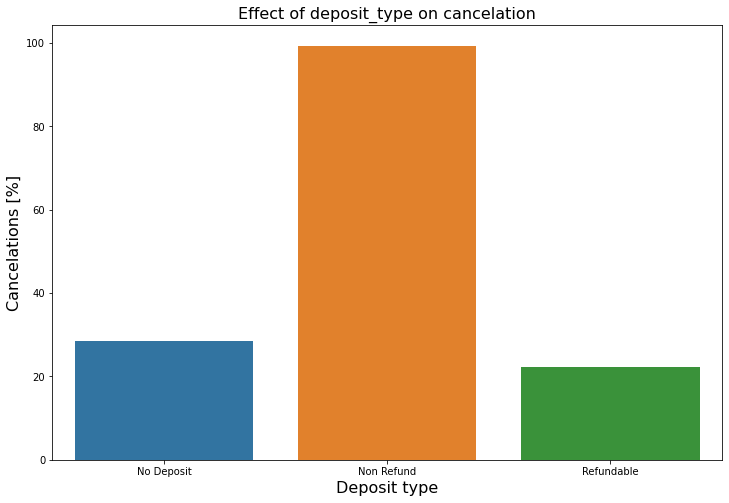

In [19]:
# group data for deposit_type:
deposit_cancel_data = full_data.groupby("deposit_type")["is_canceled"].describe()

#show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x=deposit_cancel_data.index, y=deposit_cancel_data["mean"] * 100)
plt.title("Effect of deposit_type on cancelation", fontsize=16)
plt.xlabel("Deposit type", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.show()

As opposed to Booking Lead Times and Average Daily Rates, the deposit type data seemed to suggest that bookings made with non-refundable deposits paid led to the highest cancellation rate. However, the team was not able to find any plausible explanation for this observation. 

In [20]:
full_data.groupby("deposit_type").count()["is_canceled"]

deposit_type
No Deposit    104461
Non Refund     14587
Refundable       162
Name: is_canceled, dtype: int64

In [21]:
full_data.groupby("deposit_type").mean()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
deposit_type,,,,,,,,,,,,,,,,,,,,
No Deposit,0.284020,88.841951,2016.173950,27.133208,15.815223,0.969615,2.555633,1.865806,0.118599,0.009085,0.035295,0.042044,0.154938,0.247030,78.745503,11.175874,1.518040,103.685436,0.071184,0.651726
Non Refund,0.993624,212.908891,2016.031466,27.448619,15.595462,0.621718,2.091109,1.811407,0.000617,0.000000,0.004387,0.411462,0.010626,0.012477,47.480016,6.215809,7.992253,89.964017,0.000069,0.001782
Refundable,0.222222,152.098765,2016.141975,20.932099,23.456790,0.975309,2.851852,1.907407,0.030864,0.000000,0.024691,0.000000,0.018519,0.592593,56.185185,133.666667,9.586420,76.209753,0.123457,0.141975


In [22]:
full_data.groupby("deposit_type")["is_canceled"].value_counts()

deposit_type  is_canceled
No Deposit    0              74792
              1              29669
Non Refund    1              14494
              0                 93
Refundable    0                126
              1                 36
Name: is_canceled, dtype: int64

In [23]:
full_data.loc[full_data["deposit_type"]=="Non Refund"].describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,14587.000000,14587.000000,14587.000000,14587.000000,14587.000000,14587.000000,14587.000000,14587.000000,14587.000000,14587.0,14587.000000,14587.000000,14587.000000,14587.000000,14587.000000,14587.000000,14587.000000,14587.000000,14587.000000,14587.000000
mean,0.993624,212.908891,2016.031466,27.448619,15.595462,0.621718,2.091109,1.811407,0.000617,0.0,0.004387,0.411462,0.010626,0.012477,47.480016,6.215809,7.992253,89.964017,0.000069,0.001782
std,0.079595,133.324402,0.730267,13.331718,8.699557,0.819541,1.152321,0.393992,0.032062,0.0,0.066095,1.992486,0.443376,0.125499,85.384630,39.580930,29.496511,53.389570,0.008280,0.045317
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000
25%,1.000000,103.000000,2015.000000,17.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,62.800000,0.000000,0.000000
50%,1.000000,183.000000,2016.000000,25.000000,16.000000,0.000000,2.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,86.000000,0.000000,0.000000
75%,1.000000,304.000000,2017.000000,39.000000,23.000000,1.000000,3.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,38.000000,0.000000,0.000000,110.000000,0.000000,0.000000
max,1.000000,629.000000,2017.000000,53.000000,31.000000,7.000000,16.000000,3.000000,2.000000,0.0,1.000000,26.000000,29.000000,4.000000,495.000000,504.000000,391.000000,5400.000000,1.000000,2.000000


Further investigation revealed that the bookings with non-refundable deposits had the following characteristics: 
 - long lead times
 - usually only for adults with no kids/babies
 - relatively low average daily rate
 - does not require parking spaces nor special requests

While the non-refundable deposit bookings only made up about 14,000 bookings out of the total 100,000+, a whopping 99% of them led to cancellation. This also explains this feature is the most important feature in the decision tree model. It is suggested for the hotel to carry out further investigation and data collection to determine the reasons behind such a tendency.

For example, the hotel can collect a new set of booking data (e.g. 2018 to 2020) for comparison. 

## Potential Revenue Loss Prevention ##

In [24]:
yhat=RF_model_pipe.predict(X)

# new column for predicted cancellations
full_data['pred_cancel'] = yhat

# Compute revenue from nights and average daily rate
full_data['total_nights'] = full_data['stays_in_weekend_nights'] + full_data['stays_in_week_nights']
full_data['revenue'] = full_data['total_nights'] * full_data['adr']

# revenue loss from cancellation
revenue_loss = full_data['revenue'].where(full_data['is_canceled']==1).sum()

# potential revenue loss prevented from prediction
prevented_loss = full_data['revenue'].where((full_data['pred_cancel']==1) & (full_data['is_canceled']==1)).sum()

In [25]:
print(f"Total Revenue Loss = ${revenue_loss:,}")
print(f"Potential Revenue Loss Prevented = ${prevented_loss:,}")

Total Revenue Loss = $16,727,237.12
Potential Revenue Loss Prevented = $16,561,032.08
